In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['font.sans-serif']=['Kaiti SC']
plt.rcParams['axes.unicode_minus']=False  

# read data
data = pd.read_csv('bankrupt.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bianh         6272 non-null   int64  
 1   com_name      6272 non-null   object 
 2   com_addr      6272 non-null   object 
 3   cat           6272 non-null   object 
 4   se_cat        6271 non-null   object 
 5   com_des       6271 non-null   object 
 6   born_data     6272 non-null   object 
 7   death_data    6272 non-null   object 
 8   live_days     6272 non-null   int64  
 9   financing     6272 non-null   object 
 10  total_money   805 non-null    float64
 11  death_reason  1419 non-null   object 
 12  invest_name   600 non-null    object 
 13  ceo_name      4839 non-null   object 
 14  ceo_des       4838 non-null   object 
 15  ceo_per_des   4839 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory usage: 784.1+ KB


In [ ]:
data['com_addr'].unique()

## 地理分布数据分析

### 地图可视化

In [ ]:
# aggregate data
geo_dis = data.groupby('com_addr').size().to_frame()
# reset index, revert index to normal column
geo_dis = geo_dis.reset_index()
# rename columns
geo_dis.columns = ['name','number']
# sort and reindex
geo_dis = geo_dis.sort_values(by='number',ascending=False).reset_index(drop=True)
geo_dis.head()
# geo_dis

In [ ]:
import geopandas as gpd
# read in shape file and rename column
geo_data = gpd.read_file('shapefile/gadm36_CHN_1.shp')
geo_data.rename(columns={'NL_NAME_1':'name'},inplace=True)
# geo_data.info()

# select only name and geometry column
geo_data = pd.DataFrame(geo_data,columns=['name','geometry'])
# geo_data.info()


In [ ]:
# join geo_data and geo_dis
map_data = pd.merge(left=geo_data,right=geo_dis,on='name',how='left')
map_data.fillna(0,inplace=True)
# create GeoDataFrame
map=gpd.GeoDataFrame(data=map_data)
# plot map
bins = [50,100,300,500,1000]
map.plot(
    column='number',
    cmap='Reds',
    edgecolor='0.5',
    legend=True,
    legend_kwds={
        'loc':'lower left',
        'fmt':'{:.0f}'
    },
    scheme='UserDefined',
    classification_kwds={
        'bins' : bins,
    }
)


In [ ]:
# top 10 cities
top_geo_dis = geo_dis.nlargest(10,columns='number')
top_geo_dis = top_geo_dis.iloc[::-1]

# plot chart

top_geo_dis = top_geo_dis.set_index(keys='name')
top_geo_dis.index.name = None
ax = top_geo_dis.plot.barh(
    color='#6B0808',
    legend=None, # no legend
    title='Cities with Most Bankrupt Companies, Top 10'
)
# add numbers
for bar_container in ax.containers:
    ax.bar_label(bar_container,label_type='edge',size=7,padding=2)
# grid line
ax.grid(linestyle=':',axis='x',alpha=0.3)



## 行业分析

In [ ]:
# aggregate data, pivot table
industry_dis = data.pivot_table(index=['cat'],values='com_name',aggfunc='count').sort_values(by='com_name')
# rename columns and index
industry_dis.rename(columns={'com_name':'公司数量'},inplace=True)
industry_dis.index.name= None
# plot
ax = industry_dis.plot.barh(color='#6B0808',title='Number of Bankrupt Company In Different Industries',legend=False)
ax.bar_label(ax.containers[0],label_type='edge',padding=2,size=7)
ax.grid(linestyle=':',axis='x',alpha=0.3)

## 行业细分分析

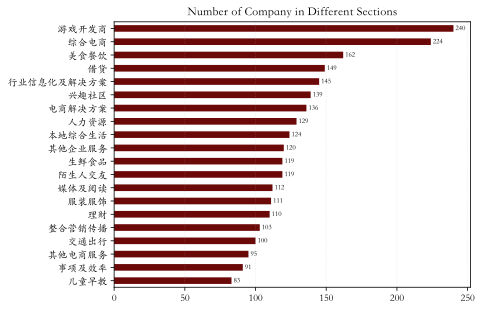

In [4]:
section_dis = data.pivot_table(index=['se_cat'],values='com_name',aggfunc='count').nlargest(columns='com_name',n=20)[::-1]
section_dis.index.name = None
section_dis.rename(columns={'com_name':'公司数量'},inplace=True)

# chart
ax = section_dis.plot.barh(color='#6B0808',legend=False,title='Number of Company in Different Sections')
ax.bar_label(ax.containers[0],label_type='edge',size=7,padding=2)
ax.grid(linestyle=':',axis='x',alpha=0.3)


## 年份分析

In [ ]:
# preprocess year
data['born_year'] = data['born_data'].str.split('-').str[0].astype(int)
data['death_year'] = data['death_data'].str.split('-').str[0].astype(int)

end_year = data['born_year'].max()
begin_year = end_year-10

born_yr_dis = data.groupby('born_year').size().loc[begin_year:end_year]
born_yr_dis.index.name='year'
born_yr_dis.name = 'number of born company'

death_yr_dis = data.groupby('death_year').size().loc[begin_year:end_year]
death_yr_dis.index.name='year'
death_yr_dis.name = 'number of dead company'

yr_dis = pd.merge(born_yr_dis,death_yr_dis,on='year')
yr_dis.index.name = None

title = 'Number of Born and Death Company from '+ str(begin_year) +' to '+str(end_year)
ax = yr_dis.plot.bar(
    color=['#B4B4B4','#6B0808'],
    title=title
)

for container in ax.containers:
    ax.bar_label(container,size=6,color='k')




## 存活时长分析

In [ ]:

data = data[data['live_days'] >= 0]
bins = [0,365-1,365*2-1,365*3-1,365*4-1,365*5-1,365*10-1,float('inf')]
labels = ['<1 yrs', '1-2 yrs', '2-3 yrs', '3-4 yrs', '4-5 yrs', '5-10 yrs', '10+ yrs']
data['survival time category'] = pd.cut(data['live_days'],bins=bins,labels=labels)
survival_time_dis = data.groupby('survival time category').size()

# chart 
survival_time_dis.plot.pie(
    textprops={'fontsize': 7},
    colors=['#004c6d','#135e83','#23709a','#3283b2','#4097ca','#4eabe3','#5dbffc'],
    startangle=90,
    autopct='%1.2f%%',
    title='Number of Company Segemented by Survial Year'
)